In [2]:
from PreFRBLE.convenience import *
from PreFRBLE.estimate_redshift import *
from PreFRBLE.plot import *
from PreFRBLE.likelihood import *
from PreFRBLE.physics import *
from PreFRBLE.sample import *

## Inference of intergalactic magnetic field
Here we infer the index $\alpha$ relation magnetic field strength to over-density in the IGM (see notebook model/IGMF)
$$|B|\propto \rho^\alpha .$$
This is done by a combined inference of DM and RM, obtaining the likelihood of source redshift from DM providing more detailed investigation of the likelihood of $\alpha$ from RM.
Thus, our approach exploits the full information entailed in each measure instead of reducing to their ratio. 
Comparing estimates of different choices of $\alpha$ in our benchmark scenario, we show that FRBs potentially probe the IGMF dotn to current lower limits set by Neronov & Vovk 2011.

Though RM depends on IGM baryon content $f_{\gm IGM}$ just as DM does (cf. notebook joint-analysis f_IGM population), the combined inference of $\alpha$ and $f_{\rm IGM}$ is erratic.
We thus consider the case that a good estimate on $f_{\rm IGM} \approx 0.9$ is provided by the much richer sample of FRB observed without reasonable extragalactic RM.
Further, for the case of such high $f_{\rm IGM}$ we found the redshift distribution following SMD to produce the best results, thus assume this here too.

Since no sufficient sample of FRBs with RM is available as of yet, we investigate the required size of that sample to improve on current constraints on the IGMF.


In [3]:
## realistic benchmark scenario
scenario = {
    'IGM' : ['primordial'],
    'Host' : ['Rodrigues18'],
    'Inter' : ['Rodrigues18'],
    'Local' : ['Piro18/wind'],
    'N_inter' : True
}

## investigated range of alpha
alphas = np.arange(1.,9.1,1.0)/3


Assuming $f_{\rm IGM} = 0.9$, $\alpha=9/3$ and population=SMD, we use mock catalogs of increasing size to see how many FRBs observed with CHIME are required to derive an upper limit on the IGMF-density-relation $\alpha$.
#### !!! this takes a little while

In [9]:
f_IGM = 0.9
alpha = 9./3
population = 'SMD'
telescope = 'CHIME'

scenario_test = {
    'IGM' : ['primordial'],
    'Host': ['Heesen11/dirty'],
    'Local': ['Piro18/wind'], 
}

scenario_ref = scenario.copy()
#scenario_ref = scenario_IGM.copy()
scenario_ref['IGM'] = ['alpha{:.0f}-3rd_C{:.0f}'.format(alpha*3 ,f_IGM*1000)]

print( scenario_ref)

N_N = 10

Ns = (10.**np.linspace(1,5,N_N)).astype('i')

tries = 10 # number of repetitions to obtain error on bayes factors

measureable = True # consider that RM < RM_min are not observable?

Bayes = np.zeros( [ len(alphas), len(Ns) ] )
Bayes_std = np.zeros( [ 2, len(alphas), len(Ns) ] )

for i_N, N in enumerate(Ns):
#for i_N in trange(len(Ns )):
#    N = Ns[i_N]
    bayes = np.zeros( [ len( alphas ), tries ] )
    for i in trange(tries, desc='tries for N={}'.format(N)):
#        FRBs_mock = FakeFRBs( measureable=False, measures=['DM','RM'], N=50, telescope=telescope, population=population, **scenario_ref )# **scenario0 )
        FRBs_mock = FakeFRBs( measures=['DM','RM'], N=N, telescope=telescope, population=population, measureable=measureable, **scenario_ref )# **scenario0 )
        DMs = FRBs_mock['DM']
        RMs = FRBs_mock['RM']
        zs = FRBs_mock['redshift']

    
        P0 = LikelihoodCombined( DMs=DMs, RMs=RMs, scenario=scenario_ref, telescope=telescope, population=population, measureable=measureable )
        for i_a, alpha in enumerate( alphas ):
            tmp = scenario_ref.copy()
            tmp['IGM'] = [ 'alpha{:.0f}-3rd_C{:.0f}'.format(alpha*3 ,f_IGM*1000) ]
            
                
#            print(tmp)
#            bayes[i_a,i] = BayesFactorCombined( DMs=DMs, RMs=RMs, scenario1=tmp, scenario2=scenario0, population=population, telescope=telescope)
            bayes[i_a,i] = 1 if tmp == scenario_ref else np.prod( LikelihoodCombined( DMs=DMs, RMs=RMs, scenario=tmp, telescope=telescope, population=population, measureable=measureable ) / P0 )

    Bayes[:,i_N], Bayes_std[:,:,i_N] = LogMeanStd( bayes, axis=1 )

tries for N=10:   0%|          | 0/10 [00:00<?, ?it/s]

{'N_inter': True, 'Host': ['Rodrigues18'], 'Inter': ['Rodrigues18'], 'IGM': ['alpha9-3rd_C900'], 'Local': ['Piro18/wind']}


/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:66: RuntimeWarning: divide by zero encountered in power
  res =  ( P*np.diff(x)*N )**-0.5
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:267: RuntimeWarning: invalid value encountered in double_scalars
  dev[ib] += add**2 * ( np.sum( ( devs[i_f][ix]*f[ix]*np.diff(x_) )**2 ) /np.sum( ( f[ix]*np.diff(x_) )**2 )  + dev_weights[i_f]**2 )
tries for N=100000:  20%|██        | 2/10 [07:25<29:43, 222.89s/it]/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:1166: RuntimeWarning: invalid value encountered in true_divide
  result_dev = np.sqrt( result_dev ) / result
tries for N=100000: 100%|██████████| 10/10 [39:47<00:00, 238.72s/it]
/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/physics.py:406: RuntimeWarning: divide by zero encountered in log10
  mean_log = np.mean( np.log10( data ), axis=axis )
/data/PreFRBLE/venv_PreFRBLE/lib/python3

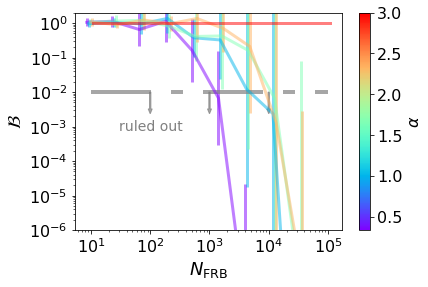

In [37]:
## plot results

fig, ax = plt.subplots()
plt.loglog()
for i_a, color in enumerate( Rainbow(alphas) ):
    if i_a % 2:
        continue
    plt.errorbar( Ns*(1-0.15+0.03*i_a), Bayes[i_a], yerr=Bayes_std[:,i_a], color=color, alpha=0.5, lw=3 )
    alpha = alphas[i_a]

    
#for x, y, alpha in zip( [2e1, 2e2, 1e3, 5e3], [1e-6,1e-6,1e-6,1e-6],  alphas[alphas<5./3] ):
#    plt.text( x, y, r"$\alpha=\frac{{{:.0f}}}{{3}}$".format(alpha*3), fontsize=16)    
#plt.text( 3e3, 1e-1, r"$\alpha \geq \frac{{5}}{{3}}$", fontsize=16)    

Colorbar( alphas, label=r"$\alpha$" )
plt.xlabel( r"$N_{\rm FRB}$", fontdict={'size':18 } )
plt.ylabel( r"$\mathcal{B}$", fontdict={'size':18 } )
plt.ylim(1e-6,2)
PlotLimit(ax=ax, x=[Ns[0],Ns[-1]], y=[1e-2,1e-2], lower_limit=False, label='ruled out', arrow_number=3, shift_text_vertical=-9e-3, shift_text_horizontal=-8.99e2)
ax.tick_params(axis='both', which='major', labelsize=16)
AllSidesTicks(ax)
plt.show()

The result shows that 1000-2000 FRBs at least have to be observed with $\rm RM_{EG} \geq 1 ~rad ~m^{-2}$ in order to improve on current limits on the IGMF, corresponding to $\alpha=\frac{1}{3}$, while most values of $\alpha < \frac{9}{3}$ can likely be ruled out with few $10^4$, certainly with $10^5$ FRBs with reasonable extragalactic RM.
Obviously, this conclusion higly depends on the assumptions and might change considering different models.
Still, it certainly shows the potential of FRBs to constrain the IGMF with unprecedented precision, once SKA provides a huge sample of systematically observed FRBs.